<a href="https://colab.research.google.com/github/adammoss/MLiS2/blob/master/examples/unsupervised/rbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [0]:
tf.random.set_seed(1)

In [5]:
print(tf.__version__)

2.1.0


In [0]:
class RBM:
    
  def __init__(self, input_size, hidden_size, lr=1.0, batchsize=100):

      self._input_size = input_size # Size of visible layer
      self._hidden_size = hidden_size # Size of hidden layer
      self.learning_rate = lr 
      self.batchsize = batchsize      
      
      # Initialise weights to small random values
      self.w = tf.random.normal((input_size, hidden_size), stddev=0.01, dtype=np.float32)
      self.hb = tf.zeros([hidden_size], np.float32)
      self.vb = tf.zeros([input_size], np.float32)

  def prob_h_given_v(self, visible, w, hb):
      return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

  def prob_v_given_h(self, hidden, w, vb):
      return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)

  # Generate the sample probability
  def sample_prob(self, probs):
      return tf.nn.relu(tf.sign(probs - tf.random.uniform(tf.shape(probs))))

  def rbm_reconstruct(self,X):
    h = tf.nn.sigmoid(tf.matmul(X, self.w) + self.hb)
    reconstruct = tf.nn.sigmoid(tf.matmul(h, tf.transpose(self.w)) + self.vb)
    return reconstruct

  # Training method for the model
  def train(self, X, epochs=10):
      
    loss = []
    for epoch in range(epochs):
        #For each step/batch
        for start, end in zip(range(0, len(X), self.batchsize),range(self.batchsize,len(X), self.batchsize)):
            batch = X[start:end]
            
            #Initialize with sample probabilities
            
            h0 = self.sample_prob(self.prob_h_given_v(batch, self.w, self.hb))
            v1 = self.sample_prob(self.prob_v_given_h(h0, self.w, self.vb))
            h1 = self.prob_h_given_v(v1, self.w, self.hb)
            
            #Create the Gradients
            positive_grad = tf.matmul(tf.transpose(batch), h0)
            negative_grad = tf.matmul(tf.transpose(v1), h1)
            
            #Update learning rates 
            self.w = self.w + self.learning_rate *(positive_grad - negative_grad) / tf.dtypes.cast(tf.shape(batch)[0],tf.float32)
            self.vb = self.vb +  self.learning_rate * tf.reduce_mean(batch - v1, 0)
            self.hb = self.hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
            
        #Find the error rate
        err = tf.reduce_mean(tf.square(batch - v1))
        print ('Epoch: %d' % epoch,'reconstruction error: %f' % err)
        loss.append(err)
        
    return loss

In [0]:
(train_data, _), (test_data, _) =  tf.keras.datasets.mnist.load_data()
train_data = train_data/np.float32(255)
train_data = np.reshape(train_data, (train_data.shape[0], 784))
test_data = test_data/np.float32(255)
test_data = np.reshape(test_data, (test_data.shape[0], 784))

In [18]:
#Size of inputs is the number of inputs in the training set
input_size = train_data.shape[1]
rbm = RBM(input_size, 20)
err = rbm.train(train_data, 10)

Epoch: 0 reconstruction error: 0.093404
Epoch: 1 reconstruction error: 0.093206
Epoch: 2 reconstruction error: 0.090904
Epoch: 3 reconstruction error: 0.089345
Epoch: 4 reconstruction error: 0.088806
Epoch: 5 reconstruction error: 0.087180
Epoch: 6 reconstruction error: 0.088006
Epoch: 7 reconstruction error: 0.087766
Epoch: 8 reconstruction error: 0.086934
Epoch: 9 reconstruction error: 0.087257


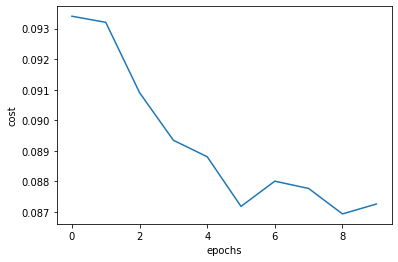

In [19]:
plt.plot(err)
plt.xlabel('epochs')
plt.ylabel('cost')
plt.show()

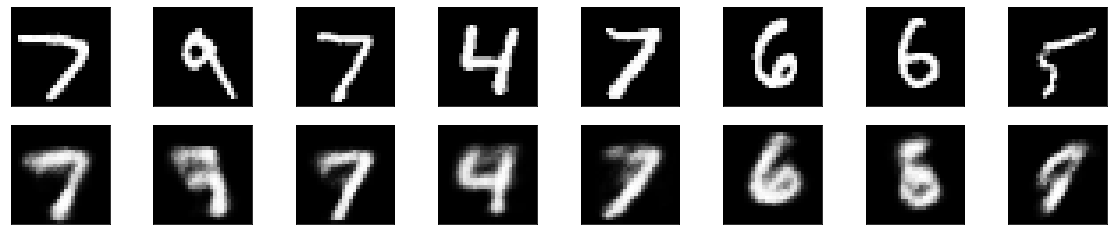

In [20]:
out = rbm.rbm_reconstruct(test_data)
# Plotting original and reconstructed images
row, col = 2, 8
idx = np.random.randint(0, 100, row * col // 2)
f, axarr = plt.subplots(row, col, sharex=True, sharey=True, figsize=(20,4))
for fig, row in zip([test_data,out], axarr):
    for i,ax in zip(idx,row):
        ax.imshow(tf.reshape(fig[i],[28, 28]), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)